In [2]:
%load_ext autoreload
%autoreload 2

from omegaconf import OmegaConf

OmegaConf.register_new_resolver(
    "relpath", lambda p: str(Path('/disk/scratch2/nkudryas/BAND-torch/notebooks/').parent / p)
)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.linear_model import Ridge 
from sklearn.decomposition import PCA
import os

from lfads_torch.post_run.band_analysis import run_posterior_sampling

Matplotlib created a temporary cache directory at /tmp/matplotlib-i533wi4b because the default path (/afs/inf.ed.ac.uk/user/n/nkudryas/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/disk/scratch2/nkudryas/micromamba/envs/band-torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset_name = 'chewie_10_07'
PATH = '/disk/scratch2/nkudryas/BAND-torch/datasets'

model_titles = ["LFADS", "BAND"]

bin_size_ms = 10

In [5]:
# best_model_dest = f"/disk/scratch2/nkudryas/BAND-torch/runs/band-torch-example/{dataset_name}/"
# model_names = ['231203_1324_exampleSingle','231203_1322_exampleSingle'] # KL=0
# model_names = ['231203_142531_exampleSingle','231203_142544_exampleSingle'] #  KL=1, but mean log-lik (should be sum)
# model_names = ['231203_153455_exampleSingle','231203_153446_exampleSingle'] # KL=1, sum log-lik
# model_names = ['231203_164845_exampleSingle','231203_164829_exampleSingle'] # KL=1, sum log-lik, now kl term is sum / batch_size
# model_names = ['231203_173548_exampleSingle','231203_173610_exampleSingle'] # KL=1, sum log-lik only along neurons/behaviors, not time
# model_names = ['231203_184750_exampleSingle','231203_184756_exampleSingle'] # KL_IC=1, KL_CO=101, sum log-lik

best_model_dest = f"/disk/scratch2/nkudryas/BAND-torch/runs/band-torch-kl/{dataset_name}"
# model_names = ['231203_210314_exampleSingle', '231203_210352_exampleSingle'] # larger beh weight 0.01 & no autoregression
# model_names = ['231203_211623_exampleSingle', '231203_221914_exampleSingle'] # add l2 on controls, AR
# model_names = ['231203_224256_exampleSingle', '231203_224304_exampleSingle'] # 64 units for generator and controller
# model_names = ['231203_224256_exampleSingle', '231203_233356_exampleSingle'] # 64 units for generator and controller, bw=0.1
# model_names = ['231203_224256_exampleSingle', '231203_233404_exampleSingle'] # 64 units for generator and controller, bw=1
# model_names = ['231203_234059_exampleSingle', '231203_234126_exampleSingle'] # 64 units for generator and controller, l2_con=1e4
# model_names = ['231204_003514_slow_start','231204_003520_slow_start'] # 64, slow start for 500 epochs instead of 80
# model_names = ['231204_100717_KLic0','231204_100805_KLic0']
# model_names = ['231204_102559_KLic100', '231204_102552_KLic100']
# model_names = ['240122_075139_kl','240122_084305_kl'] # constraned KL_IC=5, min KL_CO
# model_names = ['240122_084322_kl','240122_084316_kl'] # constraned KL_IC=5, constrained KL_CO=1
# model_names = ['240122_214739_kl','240122_214746_kl'] # min KL_IC, constrained KL_CO=0
# model_names = ['240123_100607_kl','240123_100749_kl'] # split at time_bin=25, constraned KL_IC=5, constrained KL_CO=1
# model_names = ['240123_203719_kl','240123_203713_kl'] # split at time_bin=25, min KL
# model_names = ['240124_094906_kl','240124_094913_kl'] # split at time_bin=25, KL_IC=4, KL_CO=3.5
# model_names = ['240124_095008_kl','240124_095018_kl'] # split at time_bin=25, KL_IC=4, KL_CO=3.5, 4 factors
# model_names = ['240124_112004_kl','240124_112012_kl'] # split at time_bin=25, 4 factors, AR
# model_names = ['240201_120409_lfads_4f_kl1_student','240201_120356_band_4f_kl1_student']
# model_names = ['240130_143316_lfads_40f_niceIC','240131_115626_band_40f_matched_slowly']
model_names = ['240201_134321_lfads_40f_kl1_student','240201_134408_band_40f_kl1_student']
model_dests = [f"{best_model_dest}/{model_name}" for model_name in model_names]
# models = [BAND(model_dir=model_dest) for model_dest in model_dests]

In [6]:
import torch
from hydra.utils import instantiate
from pathlib import Path
import hydra

from lfads_torch.utils import flatten

overrides={
        "datamodule": dataset_name,
        "model": dataset_name
    }
config_path="../../configs/single.yaml"
print(config_path)

# Compose the train config with properly formatted overrides
config_path = Path(config_path)
overrides = [f"{k}={v}" for k, v in flatten(overrides).items()]
with hydra.initialize(
    config_path=config_path.parent,
    job_name="get_weights",
    version_base="1.1",
):
    config = hydra.compose(config_name=config_path.name, overrides=overrides)

# Instantiate `LightningDataModule` and `LightningModule`
datamodule = instantiate(config.datamodule, _convert_="all")
model = instantiate(config.model)

ckpt_path = f'{model_dests[1]}/lightning_checkpoints/last.ckpt'
model.load_state_dict(torch.load(ckpt_path)["state_dict"])

../../configs/single.yaml


<All keys matched successfully>

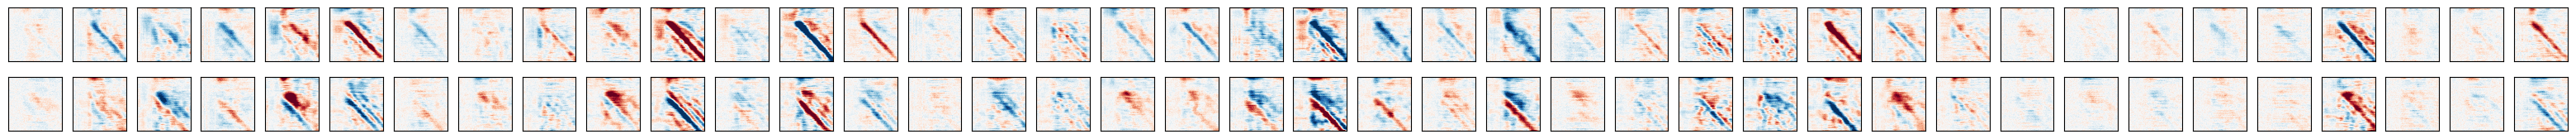

In [7]:
seq_len = config.model.recon_seq_len
in_features = config.model.behavior_readout.modules[0].in_features
out_features = config.model.behavior_readout.modules[0].out_features
beh_W = model.behavior_readout[0].layers[1].weight.T

assert beh_W.shape == (in_features*seq_len, out_features*seq_len)

beh_W = beh_W.reshape((seq_len, in_features, seq_len, out_features))

r = torch.std(beh_W)*4
fig, ax = plt.subplots(out_features, in_features, figsize=(in_features, out_features))
for j in range(in_features):
    for i in range(out_features):
        ax[i,j].imshow(beh_W[:,j,:,i].detach().numpy(), cmap='RdBu', vmin=-r, vmax=r)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

In [39]:
model

BAND(
  (encoder): Encoder(
    (ic_enc): BidirectionalClippedGRU(
      (fwd_gru): ClippedGRU(
        (cell): ClippedGRUCell(70, 64)
      )
      (bwd_gru): ClippedGRU(
        (cell): ClippedGRUCell(70, 64)
      )
    )
    (ic_linear): Linear(in_features=128, out_features=128, bias=True)
    (ci_enc): BidirectionalClippedGRU(
      (fwd_gru): ClippedGRU(
        (cell): ClippedGRUCell(70, 64)
      )
      (bwd_gru): ClippedGRU(
        (cell): ClippedGRUCell(70, 64)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.1, inplace=False)
    (ic_to_g0): Linear(in_features=64, out_features=64, bias=True)
    (rnn): DecoderRNN(
      (cell): DecoderCell(
        (gen_cell): ClippedGRUCell(2, 64)
        (fac_linear): KernelNormalizedLinear(in_features=64, out_features=40, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (con_cell): ClippedGRUCell(168, 64)
        (co_linear): Linear(in_features=64, out_fe

In [40]:
model.eval()
# zero out weight
B = torch.zeros_like(model.decoder.rnn.cell.co_linear.bias)
B[len(B) // 2:] = -10 # making variance exp(-10)
model.decoder.rnn.cell.co_linear.weight = torch.nn.Parameter(torch.zeros_like(model.decoder.rnn.cell.co_linear.weight))
model.decoder.rnn.cell.co_linear.bias = torch.nn.Parameter(B)

In [41]:
filename = model_dests[1] + '/lfads_ablated_output.h5'
run_posterior_sampling(model, datamodule, filename, num_samples=50)

100%|██████████| 1/1 [00:18<00:00, 18.22s/it]


# Run on test

In [8]:
dataset_filename = '/disk/scratch2/nkudryas/BAND-torch/datasets/Chewie_CO_FF_2016-10-07_session_vel_M1_spikes_go.h5'

with h5py.File(dataset_filename, 'r') as f:
    train_data = f['train_recon_data'][:]
    valid_data = f['valid_recon_data'][:]
    train_inds, valid_inds = f["train_inds"][:], f["valid_inds"][:]
    valid_epoch = f["valid_epoch"][:]
    true_train_beh = f['train_vel'][:]
    true_valid_beh = f['valid_vel'][:]
    true_target_direction = f['valid_target_direction'][:]

In [17]:
def merge_train_valid(train_data, valid_data, train_inds, valid_inds):
    n_samples = len(train_data) + len(valid_data)
    merged_data = np.full((n_samples, *train_data.shape[1:]), np.nan)
    merged_data[train_inds] = train_data
    merged_data[valid_inds] = valid_data
    return merged_data

# Get the paths to all data files
both_factors = []
both_controls = []
both_rates = []
both_ics = []
both_behaviors = []
lin_decoded_behs = []
seq2seq_decoded_behs = []
control_decoded_behs = []
for model_name in model_names:
    if 'band' in model_name:
        data_path = os.path.join(best_model_dest,model_name,'lfads_ablated_output_sess0.h5')
    else:
        data_path = os.path.join(best_model_dest,model_name,'lfads_output_sess0.h5')
    bin_width_sec = 0.01 # chewie
    # Data is binned at 10 ms
    with h5py.File(data_path) as f:
        print(f.keys())
        # Merge train and valid data for factors and rates
        train_inds, valid_inds = f["train_inds"][:], f["valid_inds"][:]
        factors = f["valid_factors"][:]
        rates = f["valid_output_params"][:] / bin_width_sec
        behavior = f["valid_output_behavior_params"][:]
        controls = f['valid_gen_inputs'][:]
        ic = f['valid_gen_init'][:]

        train_factors = f["train_factors"][:]
        train_controls = f['train_gen_inputs'][:]
        train_ic = f['train_gen_init'][:]
    
    # train Ridge regression to predict behavior from factors (0lag)
    X_train = train_factors.reshape(-1,train_factors.shape[-1])
    Y_train = true_train_beh.reshape(-1,true_train_beh.shape[-1])
    X_test = factors.reshape(-1,factors.shape[-1])
    ridge = Ridge(alpha=1).fit(X_train, Y_train)
    Y_pred_0lag = ridge.predict(X_test).reshape(true_valid_beh.shape)

    # Ridge seq2seq
    X_train = train_factors.reshape(train_factors.shape[0],-1)
    Y_train = true_train_beh.reshape(true_train_beh.shape[0],-1)
    X_test = factors.reshape(factors.shape[0],-1)
    ridge = Ridge(alpha=1).fit(X_train, Y_train)
    Y_pred_seq2seq = ridge.predict(X_test).reshape(true_valid_beh.shape)

    # Ridge from control inputs (seq2seq)
    X_train = train_controls.reshape(train_controls.shape[0],-1)
    Y_train = true_train_beh.reshape(true_train_beh.shape[0],-1)
    X_test = controls.reshape(controls.shape[0],-1)
    ridge = Ridge(alpha=1).fit(X_train, Y_train)
    Y_pred_control = ridge.predict(X_test).reshape(true_valid_beh.shape)

    # PCA on initial conditions
    pca = PCA(n_components=2)
    pca.fit(train_ic)
    ic_pca = pca.transform(ic)
    print(train_ic.shape,ic_pca.shape)
            
    both_factors.append(factors)
    both_controls.append(controls)
    both_rates.append(rates)
    both_ics.append(ic_pca)
    both_behaviors.append(behavior)
    lin_decoded_behs.append(Y_pred_0lag)
    seq2seq_decoded_behs.append(Y_pred_seq2seq)
    control_decoded_behs.append(Y_pred_control)

<KeysViewHDF5 ['train_behavior', 'train_co_means', 'train_co_stds', 'train_con_states', 'train_encod_data', 'train_epoch', 'train_factors', 'train_gen_init', 'train_gen_inputs', 'train_gen_states', 'train_ic_mean', 'train_ic_std', 'train_inds', 'train_output_behavior_params', 'train_output_params', 'train_pos', 'train_recon_data', 'train_target_direction', 'train_vel', 'valid_behavior', 'valid_co_means', 'valid_co_stds', 'valid_con_states', 'valid_encod_data', 'valid_epoch', 'valid_factors', 'valid_gen_init', 'valid_gen_inputs', 'valid_gen_states', 'valid_ic_mean', 'valid_ic_std', 'valid_inds', 'valid_output_behavior_params', 'valid_output_params', 'valid_pos', 'valid_recon_data', 'valid_target_direction', 'valid_vel']>


/disk/scratch2/nkudryas/micromamba/envs/band-torch/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.60813e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


(465, 64) (116, 2)
<KeysViewHDF5 ['train_behavior', 'train_co_means', 'train_co_stds', 'train_con_states', 'train_encod_data', 'train_epoch', 'train_factors', 'train_gen_init', 'train_gen_inputs', 'train_gen_states', 'train_ic_mean', 'train_ic_std', 'train_inds', 'train_output_behavior_params', 'train_output_params', 'train_pos', 'train_recon_data', 'train_target_direction', 'train_vel', 'valid_behavior', 'valid_co_means', 'valid_co_stds', 'valid_con_states', 'valid_encod_data', 'valid_epoch', 'valid_factors', 'valid_gen_init', 'valid_gen_inputs', 'valid_gen_states', 'valid_ic_mean', 'valid_ic_std', 'valid_inds', 'valid_output_behavior_params', 'valid_output_params', 'valid_pos', 'valid_recon_data', 'valid_target_direction', 'valid_vel']>
(465, 64) (116, 2)


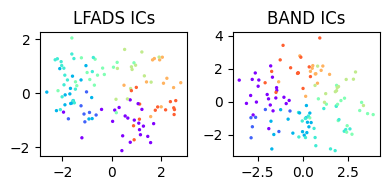

In [18]:
# substitute elements with ids
uniq_dirs = np.unique(true_target_direction)
true_label = np.array([np.where(uniq_dirs==t)[0][0] for t in true_target_direction])

from matplotlib import cm
trial_id = 0
fig, ax = plt.subplots(1,2, figsize=(4,2))
for i in range(2):
    ax[i].set_title(model_titles[i] + ' ICs')
    ax[i].scatter(*both_ics[i].T,c=cm.rainbow(true_label/8),s=2)
fig.tight_layout()

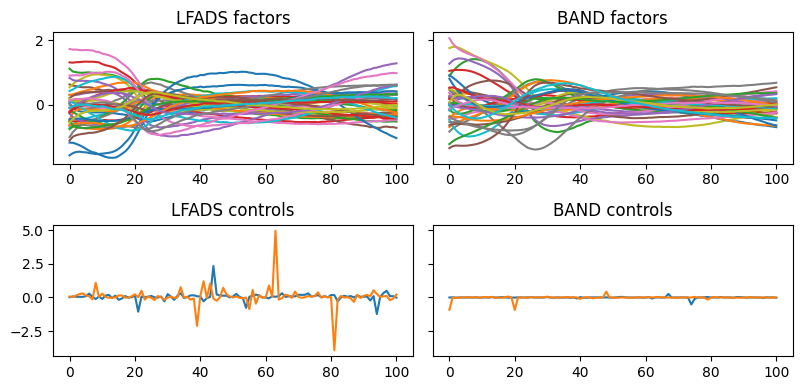

In [19]:
trial_id = 13
fig, ax = plt.subplots(2,2, figsize=(8,4),sharey='row')
for i in range(2):
    ax[0,i].plot(both_factors[i][trial_id] - both_factors[i][trial_id].mean(0))
    ax[1,i].plot(both_controls[i][trial_id])
    ax[0,i].set_title(model_titles[i] + ' factors')
    ax[1,i].set_title(model_titles[i] + ' controls')
fig.tight_layout()

In [20]:
PCA

sklearn.decomposition._pca.PCA

In [21]:
factors.shape

(116, 101, 40)

In [22]:
def R2(pred_beh,true_beh):
    return (1 - np.sum((pred_beh - true_beh)**2) / np.sum((true_beh - np.mean(true_beh))**2)) * 100

In [23]:
# p_train.gen_inputs.shape
# both_behaviors[0].shape, true_valid_beh.shape

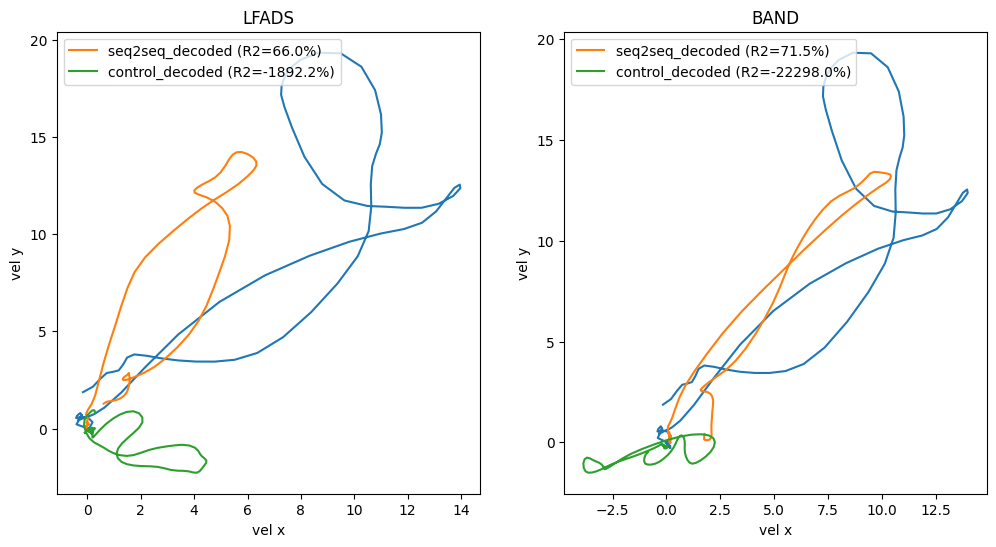

In [24]:
fig,axes = plt.subplots(1,2, figsize=(12,6))
trial_id = 1
axes[0].plot(*true_valid_beh[trial_id].T)
axes[1].plot(*true_valid_beh[trial_id].T)
for i in range(len(both_behaviors)):
    # axes[i].plot(*both_behaviors[i][trial_id].T, label=f'model_output (R2={R2(both_behaviors[i],true_valid_beh):.1f}%)')
    # axes[i].plot(*lin_decoded_behs[i][trial_id].T, label=f'lin_decoded (R2={R2(lin_decoded_behs[i],true_valid_beh):.1f}%)')
    axes[i].plot(*seq2seq_decoded_behs[i][trial_id].T, label=f'seq2seq_decoded (R2={R2(seq2seq_decoded_behs[i],true_valid_beh):.1f}%)')
    axes[i].plot(*control_decoded_behs[i][trial_id].T, label=f'control_decoded (R2={R2(control_decoded_behs[i],true_valid_beh):.1f}%)')
    axes[i].set_xlabel('vel x')
    axes[i].set_ylabel('vel y')
    axes[i].set_title(model_titles[i])
    axes[i].legend()


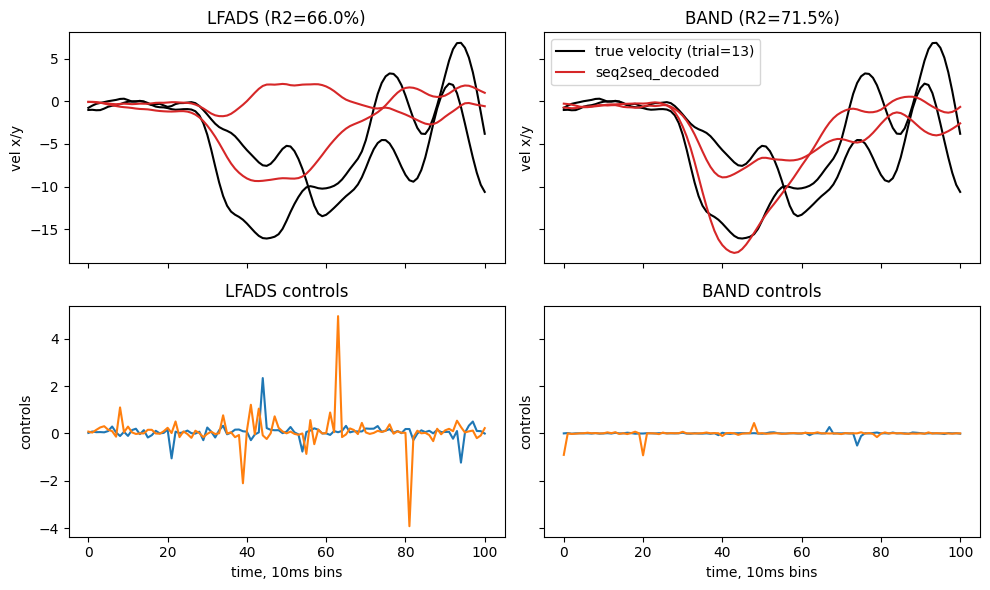

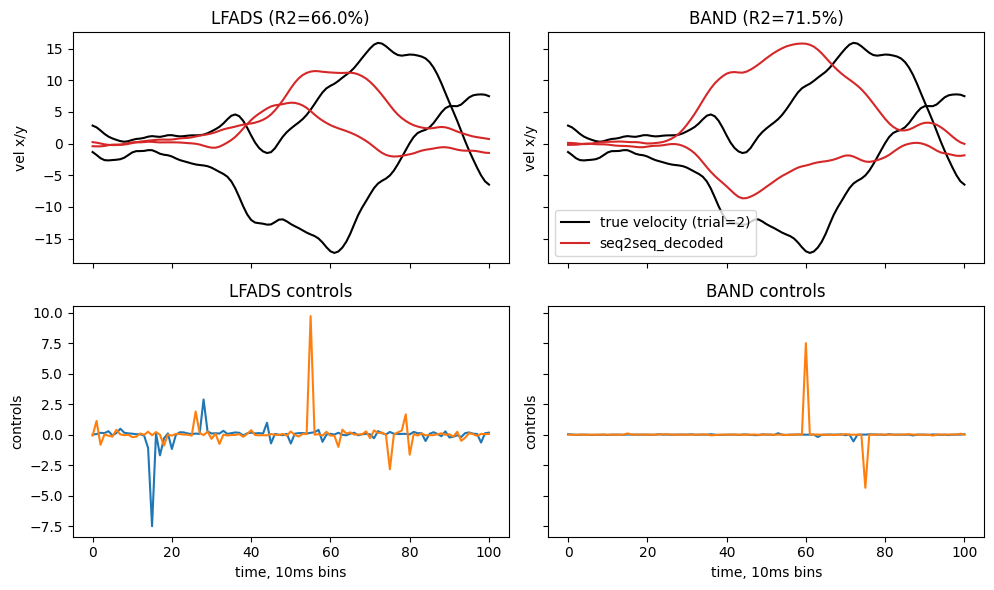

In [25]:
for trial_id in [13,2]:
    fig,axes = plt.subplots(2,2, figsize=(10,6), sharey='row', sharex=True)
    axes[0,0].plot(true_valid_beh[trial_id],c='k')
    axes[0,1].plot(true_valid_beh[trial_id],c='k',label=(f'true velocity (trial={trial_id})',None))
    for i in range(len(lin_decoded_behs)):
        # if i==1:
            # axes[0,i].plot(both_behaviors[i][trial_id], label=('model_output',None))
        # axes[i].plot(lin_decoded_behs[i][trial_id], label='lin_decoded')
        axes[0,i].plot(seq2seq_decoded_behs[i][trial_id], c='C3', label=('seq2seq_decoded',None))
        # axes[i].plot(control_decoded_behs[i][trial_id], label='control_decoded')
        axes[0,i].set_ylabel('vel x/y')
        axes[0,i].set_title(f'{model_titles[i]} (R2={R2(seq2seq_decoded_behs[i],true_valid_beh):.1f}%)')
        axes[1,i].plot(both_controls[i][trial_id])
        axes[1,i].set_ylabel('controls')
        axes[1,i].set_title(model_titles[i] + ' controls')
        axes[1,i].set_xlabel('time, 10ms bins')
    axes[0,1].legend()
    fig.tight_layout()
    fig.show()

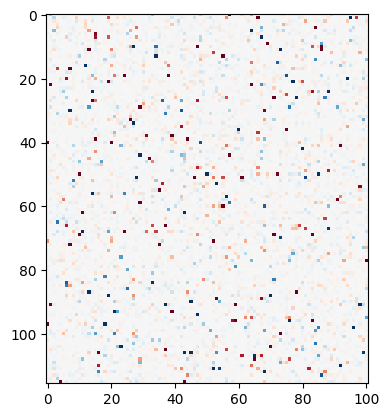

In [27]:
sort_valid_trials = np.argsort(valid_inds + valid_epoch*1000)
plt.imshow(both_controls[1][sort_valid_trials][...,1],vmin=-.5,vmax=.5,cmap='RdBu')

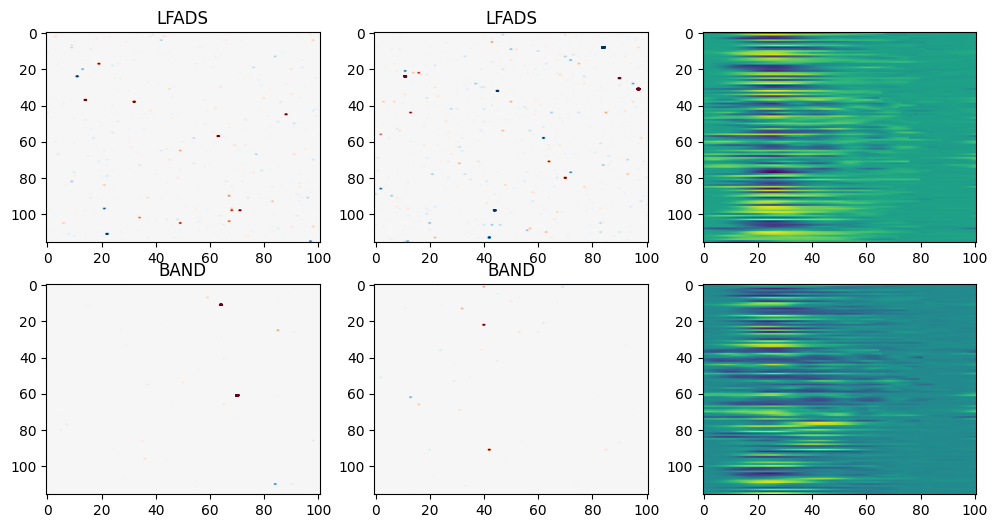

In [28]:
max_loc = np.abs(true_valid_beh).max(-1).argmax(-1)[sort_valid_trials]
# arr = np.abs(true_valid_beh).max(-1)[sort_valid_trials]
fig, ax = plt.subplots(2,3, figsize=(12,6))
for i in range(2):
    for j in range(2):
        arr = both_controls[i][sort_valid_trials][...,j]
        for k in range(arr.shape[0]):
            arr[k] = np.roll(arr[k],25-max_loc[k])
        ax[i,j].imshow(arr,vmin=-50,vmax=50,cmap='RdBu',aspect='auto')
        if i==0:
            ax[i,j].set_title('LFADS')
        else:
            ax[i,j].set_title('BAND')
    arr = true_valid_beh[sort_valid_trials][...,i]
    for k in range(arr.shape[0]):
        arr[k] = np.roll(arr[k],25-max_loc[k])
    ax[i,2].imshow(arr,aspect='auto')

In [12]:
valid_epoch

array([1, 1, 1, 0, 1, 1, 0, 2, 0, 0, 2, 1, 1, 1, 0, 0, 2, 1, 1, 2, 1, 2,
       0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 1, 1, 0, 1, 0, 0, 0, 2, 2, 1, 2,
       1, 2, 1, 0, 1, 1, 1, 2, 2, 2, 1, 1, 0, 2, 2, 0, 2, 0, 2, 0, 1, 0,
       2, 2, 2, 1, 0, 1, 1, 1, 0, 1, 2, 1, 0, 2, 2, 2, 2, 1, 1, 2, 2, 0,
       2, 1, 0, 1, 2, 0, 1, 1, 2, 2, 2, 1, 1, 0, 0, 2, 0, 2, 1, 1, 2, 0,
       0, 0, 0, 1, 2, 0])